In [3]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal as normd
%matplotlib inline

# Particle resampling

The goal of this notebook is to investigate how a discrete velocity distribution of N velocities can be resampled into M others. The idea is to use the Kernel Density Estimation method

## First generate the gridded distribution from the discrete one

We first draw 1000 2D velocities from a Maxwellian distribution with $\sigma = 0.2$ and represent the discrete distribution with a scatter plot

In [21]:
v = normd(0.2,size=(2,1000))

Text(0.5, 1.0, 'Discrete distribution of N=1000 velocities')

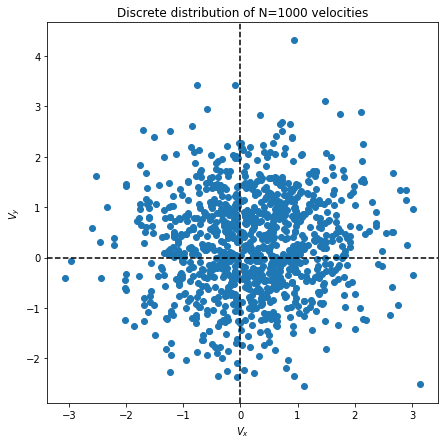

In [25]:
f,a = plt.subplots(figsize=(7,7))
a.axvline(ls="--", color="k")
a.axhline(ls="--", color="k")
a.scatter(v[0,:], v[1,:])
a.set_xlabel(r"$V_x$")
a.set_ylabel(r"$V_y$")
a.set_title("Discrete distribution of N=1000 velocities")

Now let's create the "kde kernel" using the scipy gaussian_kde method. The we build the axis coordinates we want to evaluate the kde upon and plot the result

In [7]:
import scipy.stats as stats

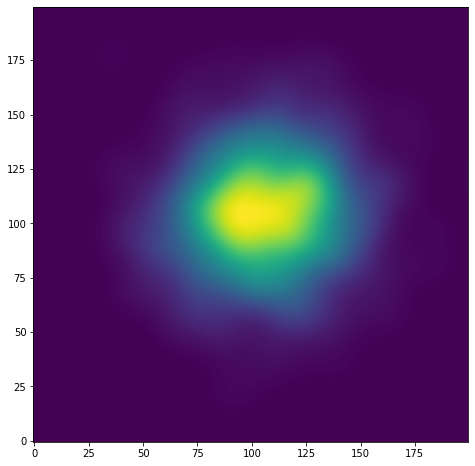

In [35]:

kde = stats.gaussian_kde(v)

# Regular grid to evaluate kde upon
v1 = np.linspace(-4,4,200)
v2 = np.linspace(-4,4,200)
vv1,vv2 = np.meshgrid(v1, v2, indexing='ij')

grid_coords = np.append(vv1.reshape(-1,1),vv2.reshape(-1,1),axis=1)

z = kde(grid_coords.T)
z = z.reshape(200,200)

plt.figure(figsize=(8,8))
plt.imshow(z,aspect=v1.ptp()/v2.ptp(), origin="lower")

## Then draw M random velocities from the gridded distribution

One method could be the rejection method

In [ ]:
#blabla

## The case of a spatially variable distribution of velocities $f(r,v)$

One question is to know the spatial scale over which to select particles to build a gridded distribution when particles are also distributed in space.

The "cell" from the field mesh seems irrelevant since it is not related to any local plasma behavior. Furthermore a cell typically embeds 100 particles, which is quite rough statistically speaking...

One idea could be to build distributions at regularly spaced locations taking all particles around that location until a certain number that is deemed sufficient is reached. That could probably easily be done by drawing a tree over the whole domain, recursively splitting space in smaller regions until there is only 1 particle in each subdivision. Browsing the tree could then provide a list of all M particles neighboring the location at which a distribution is to be built.

However that only consider a statistical argument and the region over which the distribution is made could be arbitrarily large compared to distances that could be considered relevant from a physical standpoint.

For instance, one could define a "local" physical length scale that would be the smallest one to define a distribution centered at location $r$. That distance would be such that it encloses all particles around $r$ with a Larmor radius enabling them to access $r$.

etc.

In [ ]:
# build a tree
# compute local larmor radius?